In [1]:
# Set your student number and name
student_number = "401100228"
Name = "kousha"
Last_Name = "moeini"
print("test")

test


# Libraries

In [10]:
import numpy as np
import random
import networkx as nx
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt

# Q1: Modeling Robot Navigation Using Bayesian Network  (100 Points)

# Introduction

In this assignment, we will explore the implementation of Bayesian networks to facilitate robotic navigation in an uncertain environment. A Bayesian network offers a graphical model that allows us to represent and reason about the dependencies among various uncertain variables. By leveraging the power of probabilistic reasoning, we can help a robot make informed decisions regarding its movements based on observations of external factors, such as weather conditions, battery levels, and obstacle presence.

The primary objective of this assignment is to construct a Bayesian network that models the navigation scenario, encompassing key variables that impact the robot's movement. We will implement Conditional Probability Distributions (CPDs) to define the probabilistic relationships among these variables and utilize the variable elimination algorithm to perform inference in the network. Through this process, we aim to calculate the most likely robot position given specific evidence.

# Factors and Their Relationships

In our Bayesian network, we define several critical factors that influence the robot's navigation decisions. Each factor represents a variable that carries uncertainty and plays a significant role in determining the robot's movement strategy. The key factors in our model include:

1. Weather: The weather conditions affect the performance and accuracy of the robot's sensors. Possible states include "clear," "rain," and "fog."

2. Battery Level: This variable indicates the robot's remaining energy. It can be classified as "high" or "low," impacting the likelihood of successful movement.

3. Goal Distance: This factor measures the proximity of the robot to its target destination. It is categorized as "near" or "far," which influences the robot's navigation strategy.

4. Sensor Accuracy: Dependent on the weather conditions, this variable determines how reliable the robot's sensors are in detecting obstacles. It can be either "high" or "low."

5. Obstacle Detection: Based on sensor accuracy, this variable indicates whether an obstacle is detected in the robot's path. The states are "obstacle" or "no_obstacle."

6. Move Success: This factor is influenced by the battery level and determines whether the robot can successfully move in its intended direction. It can be "success" or "failure."

7. Robot Position: The robot's moving position in the grid, which is influenced by move success, obstacle detection, and goal distance.

The relationships among these factors are captured through directed edges in the Bayesian network. For instance, the sensor accuracy is influenced by the weather, while obstacle detection relies on sensor accuracy. Moreover, move success depends on the battery level, and the robot's position is contingent on both move success and obstacle detection. These dependencies enable us to calculate joint probabilities and perform inference using the network.

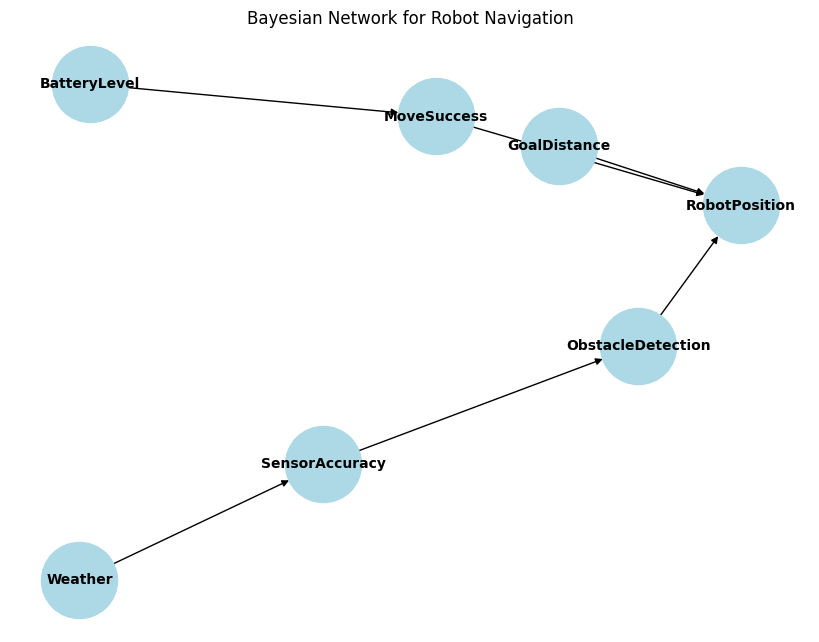

In [3]:
G = nx.DiGraph()
G.add_edges_from([
    ('Weather', 'SensorAccuracy'),
    ('BatteryLevel', 'MoveSuccess'),
    ('SensorAccuracy', 'ObstacleDetection'),
    ('ObstacleDetection', 'RobotPosition'),
    ('GoalDistance', 'RobotPosition'),
    ('MoveSuccess', 'RobotPosition')
])


pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight='bold')
plt.title('Bayesian Network for Robot Navigation')
plt.show()


# Implementing CPDs and Variable Elimination (50 points)

The implementation of Conditional Probability Distributions (CPDs) is crucial for representing the probabilistic relationships between variables in our Bayesian network. Each CPD defines a probability distribution for a variable based on its parent variables, capturing the uncertainties inherent in the system.

In this assignment, we will also implement the variable elimination algorithm, a widely used technique for exact inference in Bayesian networks. This algorithm allows us to compute the posterior probabilities of query variables, such as the robot's position, given certain observed evidence, such as current weather conditions and battery levels.

The variable elimination process consists of several steps:

1. Restrict CPDs based on observed evidence: This involves limiting the CPDs to the subset of variable assignments consistent with the observed values.
2. Eliminate irrelevant variables: Variables not involved in the query or evidence are summed out to simplify the network.
3. Multiply remaining CPDs: After eliminating variables, the remaining CPDs are combined to form a new joint distribution.
4. Normalize the result: The final step ensures that the resulting probabilities sum to one, providing a valid probability distribution for the queried variable.

In [3]:
class CPD:
    def __init__(self, variables, probabilities):
        self.variables = variables
        self.probabilities = probabilities

    def restrict(self, variable, value):
        if variable not in self.variables:
            return self
        variableIndex = self.variables.index(variable)
        myProbabilities = {}
        for assignment, prob in self.probabilities.items():
            if assignment[variableIndex] == value:
                myAssignment = assignment[:variableIndex] + assignment[variableIndex + 1:]
                myProbabilities[myAssignment] = prob
        myVariable = []
        for v in self.variables:
             if v != variable:
                myVariable.append(v)
        return CPD(myVariable, myProbabilities)
    def sum_out(self, variable):
        if variable not in self.variables:
            return self  
        variableIndex = self.variables.index(variable)
        myProbabilities = {}
        for assignment, prob in self.probabilities.items():
            myAssignment = assignment[:variableIndex] + assignment[variableIndex + 1:]
            if myAssignment in myProbabilities:
                myProbabilities[myAssignment] += prob
            else:
                myProbabilities[myAssignment] = prob
        myVariable = []
        for v in self.variables:
             if v != variable:
                myVariable.append(v)
        return CPD(myVariable, myProbabilities)
    def multiply(self, other):
        myVariable = list(set(self.variables + other.variables))
        myProbabilities = {}
        for assignment in self.probabilities:
            for assignment2 in other.probabilities:
                if all(assignment[self.variables.index(var)] == assignment2[other.variables.index(var)]
                       for var in set(self.variables) & set(other.variables)):
                    finalAssignment = tuple(assignment[self.variables.index(var)]   if var in self.variables else assignment2[other.variables.index(var)] for var in myVariable)
                    if finalAssignment in myProbabilities:
                        myProbabilities[finalAssignment] += self.probabilities[assignment] * other.probabilities[assignment2]
                    else:
                        myProbabilities[finalAssignment] = self.probabilities[assignment] * other.probabilities[assignment2]
        return CPD(myVariable, myProbabilities)
    def normalize(self):
        Sum = sum(self.probabilities.values())
        myProbabilities = {}
        for k, v in self.probabilities.items():
            myProbabilities[k] = v / Sum
        return CPD(self.variables, myProbabilities)



In [4]:
def variable_elimination(cpds, query_vars, evidence):
    for var, val in evidence.items():
        myCpds = []
        for cpd in cpds:
            if var in cpd.variables:
                myCpd = cpd.restrict(var, val)
            else:
                myCpd = cpd
            myCpds.append(myCpd)
        cpds = myCpds
    variableElimination = set()
    for cpd in cpds:
        for var in cpd.variables:
            variableElimination.add(var)
    variableElimination = set(var for cpd in cpds for var in cpd.variables) - set(query_vars) - set(evidence.keys())
    for var in variableElimination:
        variableElimination = [cpd for cpd in cpds if var in cpd.variables]
        new_factor = variableElimination[0]
        for factor in variableElimination[1:]:
            new_factor = new_factor.multiply(factor)
        new_factor = new_factor.sum_out(var)
        cpds = [cpd for cpd in cpds if var not in cpd.variables] + [new_factor]
    ans = cpds[0]
    for cpd in cpds[1:]:
        ans = ans.multiply(cpd)
    final=ans.normalize()
    return final

In [5]:
# Example usage:

cpds = [
    CPD(["A"], {('a',): 0.6, ('b',): 0.4}),
    CPD(["A", "B"], {('a', 0): 0.7, ('a', 1): 0.3, ('b', 0): 0.2, ('b', 1): 0.8}),
    CPD(["B", "C"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
    CPD(["B", "D"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
]

query_vars = ["D"]
evidence = {"A": 'a'}

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting CPD (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")

Resulting CPD (Posterior Distribution):
P(0) = 0.75
P(1) = 0.25


# CPD Tables (5 points)

The tables are given to you as png files. you need to create the CPDs and use them for inference.

In [20]:
cpds = []
weather_cpd = CPD( ["Weather"],
    {
        ("clear",): 0.5, ("rain",): 0.3, ("fog",): 0.2
    }
)
cpds.append(weather_cpd)
battery_level_cpd = CPD(["BatteryLevel"],
    {
        ("high",): 0.7, ("low",): 0.3
    }
)
cpds.append(battery_level_cpd)
goal_distance_cpd = CPD( ["GoalDistance"], 
    {
        ("near",): 0.4,("far",): 0.6
    }
)
cpds.append(goal_distance_cpd)
sensor_accuracy_cpd = CPD(
    ["Weather", "SensorAccuracy"],
    {
        ("clear", "high"): 0.8, ("clear", "low"): 0.2, ("rain", "high"): 0.4, ("rain", "low"): 0.6, ("fog", "high"): 0.2,("fog", "low"): 0.8
    }
)
cpds.append(sensor_accuracy_cpd)
obstacle_detection_cpd = CPD( ["SensorAccuracy", "ObstacleDetection"], 
    {
        ("high", "obstacle"): 0.7, ("high", "no_obstacle"): 0.3,  ("low", "obstacle"): 0.4, ("low", "no_obstacle"): 0.6
    }
)
cpds.append(obstacle_detection_cpd)
move_success_cpd = CPD( ["BatteryLevel", "MoveSuccess"],
    { 
        ("high", "success"): 0.9, ("high", "failure"): 0.1, ("low", "success"): 0.6, ("low", "failure"): 0.4
    }
)
cpds.append(move_success_cpd)
robot_position_cpd = CPD(["MoveSuccess", "ObstacleDetection", "GoalDistance", "RobotPosition"], {
        ("success", "no_obstacle", "near", "up"): 0.2,
        ("success", "no_obstacle", "near", "down"): 0.2,
        ("success", "no_obstacle", "near", "left"): 0.2,
        ("success", "no_obstacle", "near", "right"): 0.4,
        ("success", "no_obstacle", "far", "up"): 0.1,
        ("success", "no_obstacle", "far", "down"): 0.4,
        ("success", "no_obstacle", "far", "left"): 0.1,
        ("success", "no_obstacle", "far", "right"): 0.4,
        ("success", "obstacle", "near", "up"): 0.0,
        ("success", "obstacle", "near", "down"): 0.3,
        ("success", "obstacle", "near", "left"): 0.0,
        ("success", "obstacle", "near", "right"): 0.7,  
        ("success", "obstacle", "far", "up"): 0.1,
        ("success", "obstacle", "far", "down"): 0.4,
        ("success", "obstacle", "far", "left"): 0.3,
        ("success", "obstacle", "far", "right"): 0.2,
        ("failure", "no_obstacle", "near", "up"): 0.2,
        ("failure", "no_obstacle", "near", "down"): 0.2,
        ("failure", "no_obstacle", "near", "left"): 0.3,
        ("failure", "no_obstacle", "near", "right"): 0.3,
        ("failure", "no_obstacle", "far", "up"): 0.1,
        ("failure", "no_obstacle", "far", "down"): 0.1,
        ("failure", "no_obstacle", "far", "left"): 0.4,
        ("failure", "no_obstacle", "far", "right"): 0.4,
        ("failure", "obstacle", "near", "up"): 0.0,
        ("failure", "obstacle", "near", "down"): 0.3,
        ("failure", "obstacle", "near", "left"): 0.3,
        ("failure", "obstacle", "near", "right"): 0.4,
        ("failure", "obstacle", "far", "up"): 0.0,
        ("failure", "obstacle", "far", "down"): 0.2,
        ("failure", "obstacle", "far", "left"): 0.25,
        ("failure", "obstacle", "far", "right"): 0.55,
        
    }
)
cpds.append(robot_position_cpd)

In [21]:
query_vars = ["RobotPosition"]
evidence = {
            'Weather': 'clear',
            'BatteryLevel': 'low',
            'GoalDistance': 'far',
        }

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting cpd (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")


Resulting cpd (Posterior Distribution):
P(up) = 0.0744
P(down) = 0.30560000000000004
P(left) = 0.2584
P(right) = 0.3616


# Sampling Methods (30 points)

To complement our Bayesian network, we will implement three different sampling methods to estimate the posterior probabilities of the robot's position based on observed evidence:

1. Prior Sampling (10 points): In this method, we will generate samples from the joint distribution defined by the CPDs without conditioning on any evidence. The samples will be used to approximate the distribution of the query variable, such as the robot's position, before any evidence is considered.

In [37]:
def prior_sampling_query(cpds, query, evidence, num_samples=1000):
    samples = []
    queryVariable, queryValue = query
    for _ in range(num_samples):
        sample = {}
        for cpd in cpds:
            parentValues = []
            for parent in cpd.variables[:-1]:
                parentValues.append(sample.get(parent))
            parentValues = tuple(parentValues)
            probabilityDistribution = {
                outcome[-1]: prob
                for outcome, prob in cpd.probabilities.items()
                if outcome[:-1] == parentValues
            }
            if not probabilityDistribution:
                continue 
            sampledValue = random.choices(list(probabilityDistribution.keys()), list(probabilityDistribution.values()))[0]
            sample[cpd.variables[-1]] = sampledValue
        if all(sample.get(var) == val for var, val in evidence.items()):
            samples.append(sample)
    queryCount = sum(1 for sample in samples if sample.get(queryVariable) == queryValue)
    if samples:
        result = queryCount / len(samples)
    else:
        result = 0.0
    return result



In [38]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_prior = prior_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_prior}')

The estimated probability for moving up is 0.08396489828480255


2. Likelihood Weighting (10 points): This method incorporates evidence into the sampling process by assigning weights to samples based on the likelihood of the observed evidence given the sampled values. This approach allows for more accurate estimation of the posterior probabilities by prioritizing samples that align with the evidence.

In [33]:
def likelihood_weighting_query(cpds, query, evidence, num_samples=1000):
    weighted_samples = []
    queryVariable, queryValue = query
    for _ in range(num_samples):
        sample = {}
        weight = 1.0
        for cpd in cpds:
            parentvalues = []
            for parent in cpd.variables[:-1]:
                parentValue = sample.get(parent)
                parentvalues.append(parentValue)
            parentvalues = tuple(parentvalues)

            probabilityDistribution = {
                outcome[-1]: prob
                for outcome, prob in cpd.probabilities.items()
                if outcome[:-1] == parentvalues
            }
            if not probabilityDistribution:
                continue 
            if cpd.variables[-1] in evidence:
                evidence_value = evidence[cpd.variables[-1]]
                weight *= probabilityDistribution.get(evidence_value, 0)
                sample[cpd.variables[-1]] = evidence_value
            else:
                sampled_value = random.choices(list(probabilityDistribution.keys()), list(probabilityDistribution.values()))[0]
                sample[cpd.variables[-1]] = sampled_value

        weighted_samples.append((sample, weight))

    query_weight_sum = sum(weight for sample, weight in weighted_samples if sample.get(queryVariable) == queryValue)
    total_weight_sum = sum(weight for _, weight in weighted_samples)
    if total_weight_sum > 0:
        result = query_weight_sum / total_weight_sum
    else:
        result = 0.0
    return result


In [34]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_lw = likelihood_weighting_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_lw}')

The estimated probability for moving up is 0.0795


3. Gibbs Sampling (10 points): This technique is an iterative method that generates samples from the joint distribution by conditioning on the current values of other variables. It allows for efficient sampling, especially in high-dimensional spaces, by focusing on one variable at a time while keeping others fixed.



In [35]:
def gibbs_sampling_query(cpds, query, evidence, num_samples=1000):
    queryVar, queryValue = query
    sample = {var: None for cpd in cpds for var in cpd.variables}
    nonEvidenceVariable = [var for var in sample if var not in evidence]
    for var in nonEvidenceVariable:
        possibleValues = set()
        for cpd in cpds:
            if var in cpd.variables:
                for k in cpd.probabilities:
                    possibleValues.add(k[cpd.variables.index(var)])

        sample[var] = random.choice(list(possibleValues))
    sample.update(evidence)
    query_count = 0
    for _ in range(num_samples):
        for var in nonEvidenceVariable:
            condProbs = {}
            values = set()
            for cpd in cpds:
                if var in cpd.variables:
                    for k in cpd.probabilities:
                        value = k[cpd.variables.index(var)]
                        values.add(value)
            for val in values:
                sample[var] = val
                prob = 1.0
                for cpd in cpds:
                    if var in cpd.variables:
                        parentValues = []
                        for v in cpd.variables:
                            if v in sample:
                                parentValues.append(sample[v])
                        parentValues = tuple(parentValues)
                        if parentValues in cpd.probabilities:
                            prob *= cpd.probabilities[parentValues]
                condProbs[val] = prob
            total_prob = sum(condProbs.values())
            if total_prob == 0:
                continue
            for k, v in condProbs.items():
                condProbs[k] = v / total_prob
            values = list(condProbs.keys())
            probs = list(condProbs.values())
            sample[var] = random.choices(values, probs)[0]

        if sample.get(queryVar) == queryValue:
            query_count += 1

    return query_count / num_samples


In [36]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_gibbs = gibbs_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_gibbs}')

The estimated probability for moving up is 0.0879


# Robot Movement and Inference Methods (15 points)
In this assignment, we have implemented a robot navigation system that utilizes Bayesian networks to make informed decisions about its movement within a grid. The robot begins at the position
(0,0) and aims to reach the goal located at the opposite corner of the grid, while navigating potential obstacles and managing its battery level.

To determine the most likely direction the robot should move at each step, we employ various inference methods from Bayesian statistics. The robot’s movement decisions rely on the current state, which includes environmental factors such as weather conditions, battery level, distance to the goal, sensor accuracy, and obstacle detection.

run the following code to check you implementation.

In [18]:
class RobotNavigation:
    def __init__(self, grid_size=5, cpds=None, obstacles=None):
        self.grid_size = grid_size
        self.robot_position = (0, 0)  # Starting position at top-left corner
        self.goal_position = (grid_size-1, grid_size-1)  # Goal is at the bottom-right corner
        self.cpds = cpds  # Conditional probability distributions (CPDs)
        # Obstacles placed at specific positions (not randomly, to be defined)
        self.obstacles = obstacles if obstacles else [(2, 2), (1, 3)]
        self.battery_level = 10
        self.state = {
            'Weather': 'clear',
            'BatteryLevel': 'high',
            'GoalDistance': 'far',
            'SensorAccuracy': 'high',
            'ObstacleDetection': 'no_obstacle',
            'MoveSuccess': 'success'
        }

    def move_robot(self, factors, method):
        # Update state with any specific factors provided (like {'Weather': 'clear'})
        self.state.update(factors)

        query_vars = ['RobotPosition']
        evidence = self.state  # Current state is the evidence

        # Choose the inference method
        if method == 'exact_inference':
            result = variable_elimination(self.cpds, query_vars, evidence).probabilities
        elif method == 'prior':
            result = {direction: prior_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'likelihood':
            result = {direction: likelihood_weighting_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'gibbs':
            result = {direction: gibbs_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}

        # Find the most probable move
        best_move = max(result, key=result.get)
        if method == 'exact_inference': best_move = best_move[0]

        # Move the robot if possible (no obstacle in the way)
        new_position = self.get_new_position(best_move)
        if new_position not in self.obstacles and self.is_within_grid(new_position):
            self.robot_position = new_position

        # Visualize the current state of the grid
        self.visualize_grid()

        # Update the state after moving
        self.update_state(factors)

    def update_state(self, factors):
        self.state = factors
        # Update state, for example, if GoalDistance is near or an obstacle is detected
        distance_to_goal = abs(self.robot_position[0] - self.goal_position[0]) + \
                           abs(self.robot_position[1] - self.goal_position[1])
        self.state['GoalDistance'] = 'near' if distance_to_goal <= 1 else 'far'


        # Decrease battery level with each move
        self.battery_level = max(0, self.battery_level-1)

        # If battery level drops below threshold, update state
        if self.battery_level <= 5:
            self.state['BatteryLevel'] = 'low'

        # # Simulate obstacle detection based on the robot's position
        # self.state['ObstacleDetection'] = 'obstacle' if self.robot_position in self.obstacles else 'no_obstacle'

    def visualize_grid(self):
        grid = [[' ' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        grid[self.goal_position[0]][self.goal_position[1]] = 'G'  # Mark the goal
        grid[self.robot_position[0]][self.robot_position[1]] = 'R'  # Mark the robot
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = 'X'  # Mark obstacles
        for row in grid:
            print(' '.join(row))
        print('\n')

    def get_new_position(self, move):
        """Return the new position of the robot based on the direction of the move."""
        x, y = self.robot_position
        if move == 'up':
            return (x-1, y)
        elif move == 'down':
            return (x+1, y)
        elif move == 'left':
            return (x, y-1)
        elif move == 'right':
            return (x, y+1)

    def is_within_grid(self, position):
        """Check if the new position is within the grid bounds."""
        x, y = position
        return 0 <= x < self.grid_size and 0 <= y < self.grid_size
print("what?")


what?


In [19]:
# Create an instance of RobotNavigation
robot = RobotNavigation(grid_size=5, cpds=cpds, obstacles=[(2, 2), (1, 3)])

# Continue moving the robot until it reaches the goal
step = 0
while robot.robot_position != robot.goal_position:
    print(f"Robot's current position: {robot.robot_position}")
    # Move the robot using the 'exact_inference' method as an example
    robot.move_robot(factors={'Weather': 'rain'}, method='exact_inference')
    step+=1

print(f"Robot has reached the goal in {step} steps!")


Robot's current position: (0, 0)
         
R     X  
    X    
         
        G


Robot's current position: (1, 0)
         
      X  
R   X    
         
        G


Robot's current position: (2, 0)
         
      X  
    X    
R        
        G


Robot's current position: (3, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
  R     G


Robot's current position: (4, 1)
         
      X  
    X    
         
    R   G


Robot's current position: (4, 2)
         
      X  
    X    
         
      R G


Robot's current position: (4, 3)
         
      X  
    X    
         
        R


Robot has reached the goal in 9 steps!
